# Node classification with Graph Neural Networks (GNNs)
---

# 1. Introduction
---

Recently, deep learning methods showed significant performance in various research fields, including computer vision and natural language processing. Graph Neural Network approaches have been specifically designed to take advantage of these great performances while applying them to graphs.  
Learning information about object and their relations is done by following a **message passing framework**, where node representations $h_{u}^{l}$ of all nodes $u \in \mathcal{V}$ of a graph $\mathcal{G}=(\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating information from their local neighborhood $\mathcal{N}(u)$:

$$
h^{l+1}_{u} = \psi \biggl(h_{u}^{l}, f(h_{v}^{l}:v \in \mathcal{N}(u))\biggl)
$$

In the above formulation, $f$ denotes an aggregation function of the node representations, and $\psi$ an update function.  
Considering the toy graph in the image below, a graph neural network model updates a node (e.g the red node) by:  
- selecting all its neighbors, i.e grey nodes  
- aggregating information from them (using $f$) - this information can be contained in node feature  
- updating the (red) node representation (using $\psi$)

| <img src="../img/gnn_tutorial.png" alt="drawing" width="700"/> |
|:--:|
| <b>Message passing framework</b>|

This tutorial will teach you how to use **Graph Neural Networks** for **node classification** tasks. For this purpose, we will use [Scikit Network library](https://scikit-network.readthedocs.io/en/latest/), which is a Python package for the analysis of large graphs. It implements several graph algorithms (clustering, classification, ranking) as well as a Graph Neural Networks module. The whole package is based on efficient graph representation through **sparse** matrices (using [Scipy](https://scipy.org/)) and it is designed to be super easy to implement!

## 2. Node classification

#### Install and imports

In [ ]:
#pip install scikit-network

In [1]:
from IPython.display import SVG

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

from sknetwork.classification import get_accuracy_score, PageRankClassifier
from sknetwork.data import art_philo_science, load_netset
from sknetwork.gnn import GNNClassifier
from sknetwork.visualization import svg_graph

### 2.1 `art-philo-science`

Let’s first load the `art_philo_science` toy dataset. Each node in this graph represents a Wikipedia article, belonging to one out of 3 categories. A link exists between two nodes if there is a hyperlink between the webpages. In addition, each node comes with a feature vector containing the count of words in its webpage.  

The goal is to predict the category of each node: arts, philosophy or science, using both the structure of the graph and the features of the nodes.

#### 2.1.1 Data

We load all data information.

In [2]:
graph = art_philo_science(metadata=True)
adjacency = graph.adjacency
features = graph.biadjacency
names = graph.names
names_features = graph.names_col
names_labels = graph.names_labels
labels = graph.labels
position = graph.position

In [3]:
# Adjacency matrix of the graph
adjacency

<30x30 sparse matrix of type '<class 'numpy.bool_'>'
	with 240 stored elements in Compressed Sparse Row format>

In [4]:
print(names)

['Isaac Newton' 'Albert Einstein' 'Carl Linnaeus' 'Charles Darwin'
 'Ptolemy' 'Gottfried Wilhelm Leibniz' 'Carl Friedrich Gauss'
 'Galileo Galilei' 'Leonhard Euler' 'John von Neumann' 'Leonardo da Vinci'
 'Richard Wagner' 'Ludwig van Beethoven' 'Bob Dylan' 'Igor Stravinsky'
 'The Beatles' 'Wolfgang Amadeus Mozart' 'Richard Strauss' 'Raphael'
 'Pablo Picasso' 'Aristotle' 'Plato' 'Augustine of Hippo' 'Thomas Aquinas'
 'Immanuel Kant' 'Bertrand Russell' 'David Hume' 'René Descartes'
 'John Stuart Mill' 'Socrates']


In [5]:
# Feature matrix 
features

<30x11 sparse matrix of type '<class 'numpy.int64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [6]:
node_idx = 0 # index of first node

article_name = names[node_idx]
category_idx = labels[node_idx]
category_name = names_labels[category_idx]

print(f'{article_name} ({category_name}):')
for w, count in zip(features[node_idx].indices, features[node_idx].data):
    print(f'{names_features[w]} ({count})')

Isaac Newton (science):
theory (2)
invention (2)
modern (3)
century (1)
compose (1)


In [7]:
print(names_labels)
print(names_features)

['science' 'arts' 'philosophy']
['contribution' 'theory' 'invention' 'time' 'modern' 'century' 'study'
 'logic' 'school' 'author' 'compose']


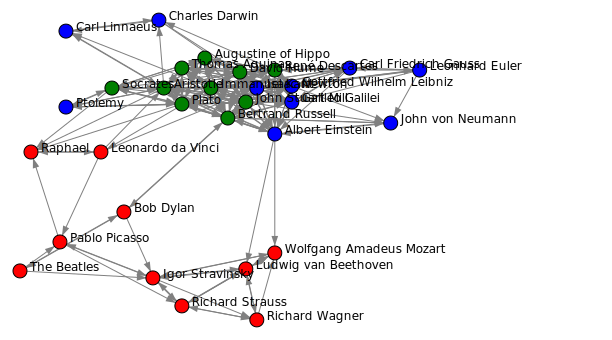

In [8]:
image = svg_graph(adjacency, position=position, names=names, labels=labels)
SVG(image)

#### 2.1.2 Implementing Graph Neural Network

Now that we have seen how Scikit-network is storing graph data, we can implement our Graph Neural Network model.  
We will develop a simple model based on **Graph Convolutional** layers (see [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), defined as:  

$$
H^{l+1} = \sigma(\bar{A}H^{l}W^{l} + b^{l})
$$
where 
- $\bar{A}$ is the normalized adjacency matrix (detailed further)
- $H^{l}$ is the node representation matrix at layer $l$. In the first layer, this matrix corresponds to the feature matrix.
- $W^{l}$ and $b^{l}$ are trainable parameters at layer $l$
- $\sigma$ is a non-linear activation function  

| <img src="../img/gcn_layer.png" alt="drawing" width="700"/> |
|:--:|
| <b>$1$-hop neighborhood information aggregation</b>|

**Initialize GNN model**  

In [9]:
# Number of labels
n_labels = len(set(labels))

n_labels

3

In [10]:
# GNN classifier with a single hidden layer
hidden_dim = 10

gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layers='GCNConv',
                    normalizations='both',
                    activations=['Relu', 'Softmax'],
                    optimizer='Adam',
                    verbose=True)

In [11]:
print(gnn)

GNNClassifier(
    GCNConv(out_channels: 10, activation: relu, use_bias: True, self_loops: True)
    GCNConv(out_channels: 3, activation: softmax, use_bias: True, self_loops: True)
)


In [12]:
print(gnn.conv1.normalization)
print(gnn.conv2.normalization)

both
both


In [13]:
print(gnn.conv1.weights_initialized)
print(gnn.conv2.weights_initialized)

False
False


**Train and predict labels**  


In [14]:
labels_pred = gnn.fit_predict(adjacency, 
                              features, 
                              labels, 
                              loss='CrossEntropyLoss',
                              n_epochs=100,
                              train_size=0.7, val_size=0, test_size=0.3)

In epoch   0, loss: 1.736, training acc: 0.353
In epoch  10, loss: 0.799, training acc: 0.647
In epoch  20, loss: 0.586, training acc: 0.824
In epoch  30, loss: 0.469, training acc: 0.824
In epoch  40, loss: 0.414, training acc: 0.941
In epoch  50, loss: 0.374, training acc: 0.882
In epoch  60, loss: 0.342, training acc: 0.941
In epoch  70, loss: 0.319, training acc: 0.941
In epoch  80, loss: 0.298, training acc: 0.941
In epoch  90, loss: 0.283, training acc: 0.941


In [15]:
gnn.history_.keys()

dict_keys(['embedding', 'loss', 'train_accuracy'])

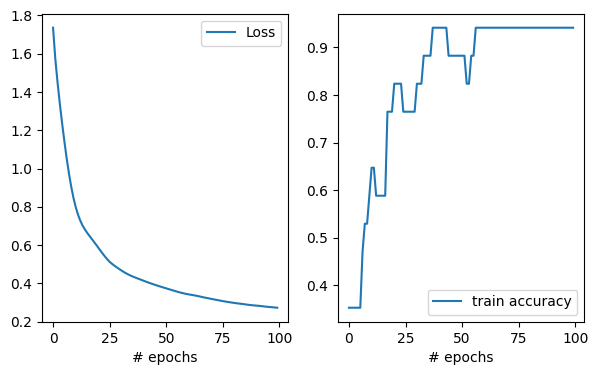

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].plot(gnn.history_.get('loss'), label='Loss')
ax[1].plot(gnn.history_.get('train_accuracy'), label='train accuracy')
for i in range(2):
    ax[i].set_xlabel('# epochs')
    ax[i].legend()

In [17]:
# Accuracy on test set
test_mask = gnn.test_mask
get_accuracy_score(labels[test_mask], labels_pred[test_mask])

0.8461538461538461

In [18]:
labels_pred

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2])

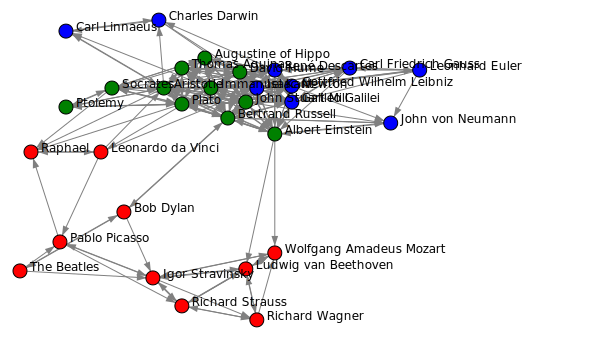

In [19]:
# Visualization
image = svg_graph(adjacency, position=position, names=names, labels=labels_pred)
SVG(image)

In [20]:
ptolemy = {i: name for i, name in enumerate(names) if 'Ptolemy' in name}
print('Ptolemy')
print(f'True label: {names_labels[labels[list(ptolemy)[0]]]}')
print(f'Predicted label: {names_labels[labels_pred[list(ptolemy)[0]]]}')

Ptolemy
True label: science
Predicted label: philosophy


#### 2.1.3 Visualizations

In [21]:
#pip install plotly

In [22]:
import pandas as pd
import plotly.express as px

In [28]:
def build_df(graph, embedding, labels_pred):
    """ Build DataFrame from graph data, node embedding and predicted labels """
    
    n = graph.adjacency.shape[0]
    
    # Select 5 features randomly
    words_sel = [graph.names_col[np.random.choice(graph.biadjacency[i].indices, 5)] for i in range(n)]

    # Get coordinates and attributes
    df_coord = pd.DataFrame(embedding, columns=['X', 'Y', 'Z'])
    df_qual = pd.DataFrame({'Article': graph.names, 
                            'Label': graph.names_labels[graph.labels], 
                            'Predicted label': graph.names_labels[labels_pred],
                            'Words': words_sel})
    df = pd.concat((df_coord, df_qual), axis=1)

    # Size of marker according to accuracy of category
    unique_labels, counts = np.unique(labels, return_counts=True)
    for lab, c in zip(unique_labels, counts):
        acc = np.sum(labels_pred[labels == lab] == lab) / c
        df.loc[df['Label'] == names_labels[lab], 'group acc'] = round(acc, 3)
    
    return df

**Embeddings over epochs**

In [29]:
embs = []
preds = []

# Train model and save embeddings before activation
gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layers='GCNConv',
                    activations=['Relu', 'Softmax'],
                    verbose=False)

df_tot = pd.DataFrame()
for i in range(100):
    pred = gnn.fit_predict(adjacency, features, labels, n_epochs=1, train_size=0.7, val_size=0., test_size=0.3,
                          random_state=42)
    embs.append(gnn.conv2.update)
    preds.append(pred)
    df_epoch = build_df(graph, gnn.conv2.update, pred)
    # Ensure that all labels are available at epoch 0 -> for Plotly legend
    if i == 0 and df_epoch['Predicted label'].nunique() < n_labels:
        diff = set(names_labels).difference(set(df_epoch['Predicted label'].unique()))
        for j, e in enumerate(diff):
            df_epoch.loc[j, 'Predicted label'] = str(e)
    df_epoch['Epoch'] = i
    df_tot = pd.concat((df_tot, df_epoch))
    
# 3d Animation using Plotly
size = 600
fig = px.scatter_3d(df_tot[df_tot['Epoch']>=15], x="X", y="Y", z="Z", animation_frame="Epoch", 
                    color="Predicted label", hover_name='Article', width=size*1.6, height=size*1.2, 
                    hover_data={'X': False, 'Y':False, 'Z': False, 
                                'Article':True, 'Label': True, 'Predicted label': True, 'Words': True},
                    range_x=[df_tot['X'].min()-1,df_tot['X'].max()+1], 
                    range_y=[df_tot['Y'].min()-1,df_tot['Y'].max()+1],
                    range_z=[df_tot['Z'].min()-1,df_tot['Z'].max()+1])
fig.update_traces(marker=dict(size=5, line=dict(width=0)))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['easing'] = 'back-in-out'
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.1, y=1.1, z=.4)
)
fig.update_layout(scene_camera=camera, autosize=False)
fig.show()

### 2.2 `Wikivitals`

We can now perform the same node classification task on a larger graph dataset. [Wikivitals](https://netset.telecom-paris.fr/pages/wikivitals.html) contains vital articles of Wikipedia in English. As for the previous dataset, a link exists between two nodes if the corresponding Wikipedia articles are referencing each other. Each node comes with a feature vector which consists of the words used in its summary.  

The task remains the same, we want to predict the category of each node in the graph, using both the structural and the feature information we got.

#### 2.2.1 Data

In [30]:
graph = load_netset('wikivitals')
adjacency = graph.adjacency
features = graph.biadjacency
names = graph.names
names_features = graph.names_col
names_labels = graph.names_labels
labels = graph.labels

Parsing files...
Done.


In [31]:
# Adjacency matrix of the graph
adjacency

<10011x10011 sparse matrix of type '<class 'numpy.bool_'>'
	with 824999 stored elements in Compressed Sparse Row format>

In [32]:
# Features of the nodes
features

<10011x37845 sparse matrix of type '<class 'numpy.int64'>'
	with 1363301 stored elements in Compressed Sparse Row format>

In [33]:
# 10 random article names
np.random.choice(names, 10)

array(['Diophantine equation', 'Rococo', 'Polar bear', 'Georges Danton',
       'August Strindberg', 'Spanish American wars of independence',
       'Cirrus cloud', 'Nth root', 'Water Margin', 'Alexander Hamilton'],
      dtype='<U62')

In [34]:
# 10 random article category
names_labels[np.random.choice(labels, 10)]

array(['History', 'Biological and health sciences', 'Everyday life',
       'Biological and health sciences', 'Technology', 'Technology',
       'History', 'Physical sciences', 'Technology',
       'Society and social sciences'], dtype='<U30')

In [35]:
i = 12

print(names[i])
words = names_features[features[i].indices]
if len(words) > 15:
    words = np.random.choice(words, 15)
print(words)

2001: A Space Odyssey (film)
['nominate' 'humanity' 'and' 'concurrently' 'monolith' 'widely'
 'narrative' 'other' 'depiction' 'in' 'who' 'possibility' 'concurrently'
 'four' 'or']


#### 2.2.2 PageRank Classifier

In [36]:
mask_train = np.ones(len(names), dtype=bool)
mask_test = np.zeros(len(names), dtype=bool)

for label in set(labels):
    index_label = np.argwhere(labels==label).ravel()
    index_test = np.random.choice(index_label, size=int(len(index_label)*0.2), replace=False)
    mask_train[index_test] = 0
    mask_test[index_test] = 1

In [37]:
# train and test nodes
print(f'# train nodes: {np.sum(mask_train)} - # test nodes: {np.sum(mask_test)}')

# train nodes: 8012 - # test nodes: 1999


In [38]:
labels_train = -np.ones(len(names), dtype=int)
labels_train[mask_train] = labels[mask_train]

In [39]:
# PageRank classifier
classifier = PageRankClassifier()
labels_pred = classifier.fit_transform(adjacency, labels_train)

In [40]:
# Format predictions
labels_pred = np.array(labels_pred.argmax(1)).ravel()

In [41]:
get_accuracy_score(labels[mask_test], labels_pred[mask_test])

0.6868434217108554

#### 2.2.3 Implementing Graph Neural Network

In [42]:
# Number of labels
n_labels = len(set(labels))

n_labels

11

In [43]:
# GNN classifier with a single hidden layer
hidden_dim = 32

gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layers='GCNConv',
                    activations=['Relu', 'Softmax'],
                    verbose=True)

In [44]:
labels_pred = gnn.fit_predict(adjacency, features, labels, 
                              train_size=0.8, val_size=0.1, test_size=0.1)

In epoch   0, loss: 21.328, training acc: 0.119, val acc: 0.118
In epoch  10, loss: 3.622, training acc: 0.340, val acc: 0.362
In epoch  20, loss: 1.424, training acc: 0.643, val acc: 0.640
In epoch  30, loss: 1.026, training acc: 0.738, val acc: 0.721
In epoch  40, loss: 0.876, training acc: 0.775, val acc: 0.775
In epoch  50, loss: 0.836, training acc: 0.784, val acc: 0.784
Early stopping.


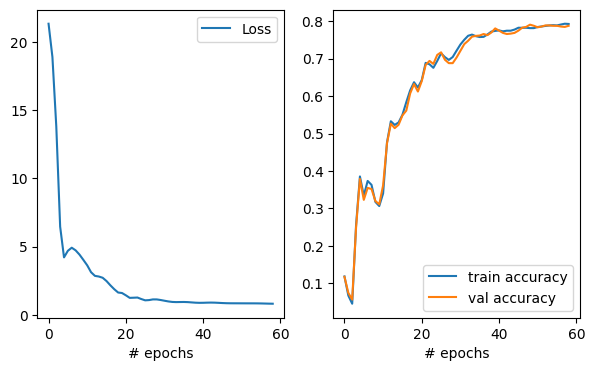

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].plot(gnn.history_.get('loss'), label='Loss')
ax[1].plot(gnn.history_.get('train_accuracy'), label='train accuracy')
ax[1].plot(gnn.history_.get('val_accuracy'), label='val accuracy')
for i in range(2):
    ax[i].set_xlabel('# epochs')
    ax[i].legend()

In [46]:
# Accuracy on test set
test_mask = gnn.test_mask
get_accuracy_score(labels[test_mask], labels_pred[test_mask])

0.8090551181102362

In [47]:
# Explore mis-predicted nodes
mispreds = labels != labels_pred

for i in names[mispreds][-5:]:
    idx = np.where(names == i)[0][0]
    print(f'Article: {i} - True label: {names_labels[labels[idx]]} - predicted label: {names_labels[labels_pred[idx]]}')

Article: Çatalhöyük - True label: History - predicted label: Technology
Article: Édith Piaf - True label: People - predicted label: Arts
Article: Émile Zola - True label: People - predicted label: Arts
Article: Ögedei Khan - True label: People - predicted label: Geography
Article: Śāriputra - True label: People - predicted label: Philosophy and religion


#### 2.2.4 Visualizations

Have a look at an interactive [Static visualization](static_3d_embedding.html) of Wikivitals embedding using GNNs.  
Here is a [dynamic](dynamic_3d_embedding.html) version, that enables to see the evolution of embedding through the GNN training.

In [151]:
#pip install umap-learn

In [48]:
import umap
import umap.plot

import plotly
from plotly import offline
import plotly.graph_objs as go

**Static**

In [49]:
# Dimension reduction of GNN embedding using UMAP
labels_unique, counts = np.unique(labels, return_counts=True)
umap_emb = umap.UMAP(n_components=3).fit_transform(gnn.conv2.update)

df = build_df(graph, umap_emb, labels_pred)
df['norm op'] = df['group acc'].apply(
                        lambda x: (x - np.min(df['group acc'])) / (np.max(df['group acc']) - np.min(df['group acc']))
                    )

traces = []
colors = px.colors.qualitative.G10 + [px.colors.qualitative.G10[0]]
for lab in labels_unique:
    sub_df = df[df['Label']==names_labels[lab]]
    traces.append(go.Scatter3d(
            x = sub_df.X,
            y = sub_df.Y,
            z = sub_df.Z,
            name = names_labels[lab],
            mode = 'markers',
            opacity = np.clip(np.array(sub_df['norm op'].values[0]), 0.1, 0.9), #0.8,
            marker = dict(size=3, line=dict(width=0), color=colors[lab]),
            text = sub_df['Article'],
            customdata = sub_df['Predicted label'],
            hovertemplate =
                "<br>Article: %{text}<br>" +
                f"<br>Label: {names_labels[lab]}<br>" +
                "<br>Pred label: %{customdata}<br>" + 
                f"<br>Category acc: {sub_df['group acc'].unique()[0]}<br>"
                "<extra></extra>"
            )
    )

layout = go.Layout(
    title='Wikivitals embedding',
    width=1000,
    height=800,
    autosize=False,
)

fig = dict(data=traces, layout=layout)

offline.iplot(fig)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [51]:
# Save plotly fig
plotly.offline.plot(fig, filename='static_3d_embedding.html')

'static_3d_embedding.html'

**Animation**

In [161]:
embs = []
preds = []
gnn = GNNClassifier(dims=[hidden_dim, n_labels],
                    layers='GCNConv',
                    activations=['Relu', 'Softmax'],
                    verbose=False)

# Save embeddings before activation layer at each epoch
for i in range(100):
    pred = gnn.fit_predict(adjacency, features, labels, n_epochs=1, train_size=0.8, val_size=0.1, test_size=0.1,
                          random_state=42)
    embs.append(gnn.conv2.update)
    preds.append(pred)

In [162]:
test_mask = gnn.test_mask
get_accuracy_score(labels[test_mask], preds[-1][test_mask])

0.8202479338842975

In [164]:
labels_unique, counts = np.unique(labels, return_counts=True)
df_tot = pd.DataFrame()
mapper = umap.UMAP(n_components=3, random_state=42).fit(embs[-1])

for i in range(50):
    
    # Dimension reduction of GNN embedding using UMAP    
    umap_emb_epoch = mapper.transform(embs[i*2])
    
    # Build DataFrame
    df_epoch = build_df(graph, umap_emb_epoch, preds[i*2])
    df_epoch['Epoch'] = i*2
    df_tot = pd.concat((df_tot, df_epoch))
    
df_tot.to_pickle("animation_df.pkl")

In [ ]:
import plotly

size = 800

fig = px.scatter_3d(df_tot_2, x="X", y="Y", z="Z", animation_frame="Epoch", animation_group="Article",
           color="Label", hover_name="Article", color_discrete_sequence=px.colors.qualitative.G10,
             width=size*1.2, height=size)
fig.update_traces(marker=dict(size=3, line=dict(width=0)))

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)
fig.update_layout(
    scene = dict(
         xaxis = dict(nticks=4, range=[df_tot_2['X'].min()-1,df_tot_2['X'].max()+1],),
         yaxis = dict(nticks=4, range=[df_tot_2['Y'].min()-1,df_tot_2['Y'].max()+1],),
         zaxis = dict(nticks=4, range=[df_tot_2['Z'].min()-1,df_tot_2['Z'].max()+1],),),
    scene_camera=camera)

fig.show()

# Save animation
plotly.offline.plot(fig, filename='dynamic_3d_embedding.html')

## Annexes

### `art-philo-science`

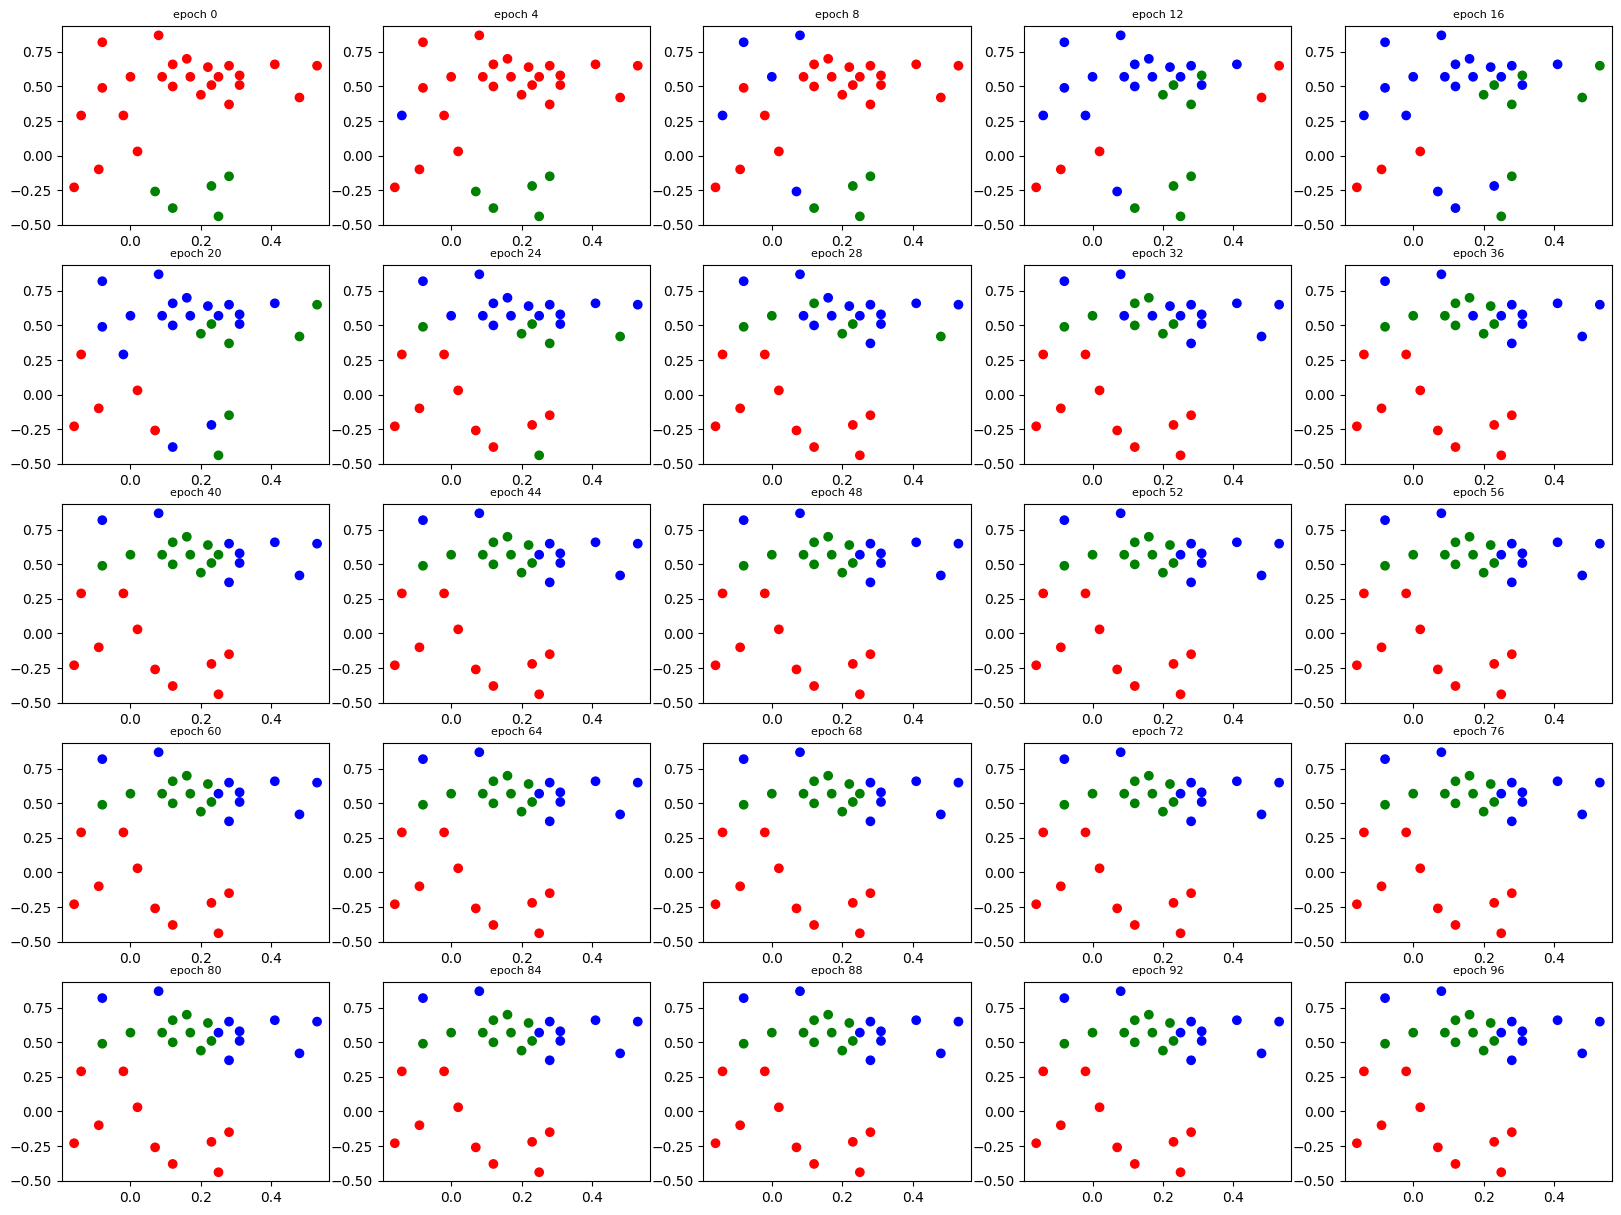

In [31]:
# 2d matplotlib
colors = np.array(['blue', 'red', 'green'])
hist = gnn.history_.get('embedding')[::4]
n_epochs = len(hist)

fig, axs = plt.subplots(5, 5, figsize=(20, 15))

for i, ax in enumerate(axs.reshape(-1)):
    labels_pred_hist = np.array(np.argmax(hist[i], axis=1))
    ax.scatter(position[:, 0], position[:, 1], color=colors[labels_pred_hist])
    ax.set_title(f'epoch {i*4}', fontsize=8);

In [24]:
# 3d static node embedding visualization using Plotly
size = 700
df = build_df(graph, gnn.conv2.update, labels_pred)
fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.8, color='Predicted label', 
                    hover_data={'X': False, 'Y':False, 'Z': False, 'group acc': True, 
                                'Article':True, 'Label': True, 'Predicted label': True, 'Words': True}, 
                    width=size*1.2, height=size, color_discrete_sequence=px.colors.qualitative.D3)
fig.show()

In [26]:
# 2d animation using Plotly
colors = np.array(['blue', 'red', 'green'])
start_idx = 30
hist = gnn.history_.get('embedding')[start_idx:]
n_epochs = len(hist) + start_idx

df_tot = pd.DataFrame()
for i in range(len(hist)):
    labels_pred_hist = np.array(np.argmax(hist[i], axis=1))
    df_epoch = build_df(graph, np.hstack((position, np.ones(position.shape[0]).reshape(-1, 1))), labels_pred_hist)
    df_epoch['Epoch'] = i + start_idx
    df_tot = pd.concat((df_tot, df_epoch))

In [37]:
# 2d Animation using Plotly
size = 700
fig = px.scatter(df_tot, x="X", y="Y", animation_frame="Epoch", 
           color="Predicted label", hover_name='Article', width=size*1.2, height=size, 
                 range_x=[-0.2,0.6], range_y=[-0.5,0.9])
fig.update_traces(marker=dict(size=10, line=dict(width=0)))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['easing'] = 'back-in-out'
fig.show()

### `Wikivitals`

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot: >

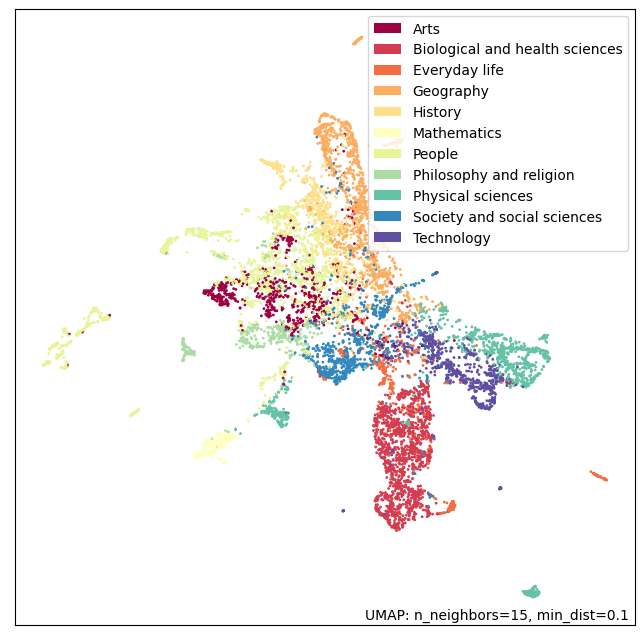

In [153]:
# Static 2d visualization
mapper = umap.UMAP().fit(gnn.conv2.update)
umap.plot.points(mapper, labels=names_labels[labels_pred])

In [ ]:
# 3d interactive using Plotly
size = 800

# Dimension reduction of GNN embedding using UMAP
labels_unique, counts = np.unique(labels, return_counts=True)
umap_emb = umap.UMAP(n_components=3).fit_transform(gnn.conv2.update)

df = build_df(graph, umap_emb, labels_pred)
fig = px.scatter_3d(df, x='X', y='Y', z='Z', opacity=0.6, color='Label', 
                    hover_data={'X': False, 'Y':False, 'Z': False, 'group acc': True, 
                                'Article':True, 'Label': True, 'Predicted label': True, 'Words': True}, 
                    width=size*1.2, height=size, color_discrete_sequence=px.colors.qualitative.G10)

fig.update_traces(marker=dict(size=3, line=dict(width=0)))
fig.show()